In [1]:
#Lenet with left,right,center and augmented AND ADDED Cropping layer AND ADDED NVIDEA Arch with ELU.
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn

from keras.models import Sequential
from keras.layers import Dense, Flatten,Lambda,Cropping2D,Dropout,MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [2]:

lines = []

#def resize_image(image):
#    #image_shape = image.shape
#    cropped_image = image[55:135, :, :]
#    image = cv2.resize(cropped_image,(64,64),interpolation=cv2.INTER_AREA)
#    return image 

def flip_images(image,angle):
    flipped_image = cv2.flip(image,1)
    flipped_angle = angle*-1.0

    return flipped_image,flipped_angle

#def augment_brightness_image(image):
#    bright_image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
#    random_brighness = .25 + np.random.uniform()
#    bright_image[:,:,2] = bright_image[:,:,2]*random_brighness

#    bright_image = cv2.cvtColor(bright_image,cv2.COLOR_HSV2BGR)
#    return bright_image

#def augment_image(image):
#    flip_prob = np.random.random()
#    if flip_prob > 0.4:
#        image = augment_brightness_image(image)
#    image = cv2.GaussianBlur(image, (3,3), 0)
#    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
#    return image

In [3]:

with open('driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        lines.append(line)

In [4]:

correction = 0.25
#images = []
#steerings = []
#updated_samples = []
#for line in lines:
#	measurements = float(line[3])
#	if abs(measurements) >= 0.05:
#		steerings.append(float(line[3]))
#		updated_samples.append(line)
#	elif np.random.random() > 0.85:
#		steerings.append(float(line[3]))
#		updated_samples.append(line)

images = []
measurements = []
samples = []
for line in lines:

    name1 = './IMG/' + line[0].split('/')[-1]
    name2 = './IMG/' + line[1].split('/')[-1]
    name3 = './IMG/' + line[2].split('/')[-1]
    #center_image = cv2.imread(name1)
    #center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
    #print (img.shape)
    images.append(name1)

    #steerings.extend(center_measurement,left_measurement,right_measurement)
    center_measurement = float(line[3])
    #left_measurement = center_measurement + correction
    #right_measurement = center_measurement - correction

    measurements.append(center_measurement)
    #steerings.append(left_measurement)
    #steerings.append(right_measurement)

    #left_image = cv2.imread(name2)
    left_measurement = center_measurement + correction
    #left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
    images.append(name2)
    measurements.append(left_measurement)


    #right_image = cv2.imread(name3)
    right_measurement = center_measurement - correction
    #right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
    images.append(name3)
    measurements.append(right_measurement)
    
samples = list(zip(images,measurements))


In [5]:

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for img,steer in batch_samples:
                #name = './IMG/' + batch_sample[0].split('/')[-1]
                image = cv2.imread(img)
                #print (img)
                steering = float(steer)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                images.append(image)
                angles.append(steering)
                
                flip_image,flip_angle = flip_images(image,steering)
                
                images.append(flip_image)
                angles.append(flip_angle)

                
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)


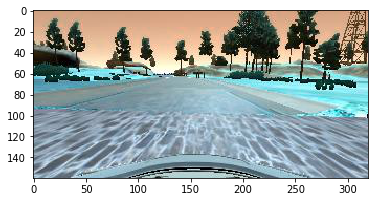

In [6]:
%matplotlib inline
img = cv2.imread('./IMG/center_2018_01_12_21_34_39_742.jpg')
plt.imshow(img)
plt.show()

In [7]:
img_numpy = np.array(images)
print (img_numpy.shape)
measurements_numpy = np.array(measurements)
print (measurements_numpy.shape)

(16887,)
(16887,)


In [8]:


train_samples, validation_samples = train_test_split(samples, test_size=0.2)

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

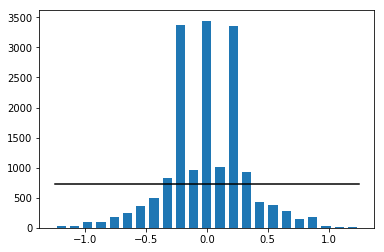

In [9]:
# print a histogram to see which steering angle ranges are most overrepresented
num_bins = 23
avg_samples_per_bin = len(measurements)/num_bins
hist, bins = np.histogram(measurements, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(measurements), np.max(measurements)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()


In [10]:
#samples = updated_samples
#num_samples = len(samples)
#samples_generated = 0
#steering_angles = None
#while samples_generated < 6*num_samples:
#    X_batch, y_batch = next(train_generator)
#    if steering_angles is not None:
#        steering_angles = np.concatenate([steering_angles, y_batch])
#    else:
#        steering_angles = y_batch
#    samples_generated += y_batch.shape[0]
 
#plt.hist(steering_angles,bins=[-0.55,-0.5, -0.45, -0.4, -0.35, -0.3,-0.25, -0.2, -0.15, -0.1,-0.05,0,0.05, 0.1,0.15, 0.2,0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55], align='left')
#plt.show()
#plt.savefig('data_distribution.png')

In [11]:

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0))))

#Implementing Nvidea architecture
#model.add(Convolution2D(24,5,5,activation='relu'))
#model.add(Convolution2D(36,5,5,activation='relu'))
##model.add(Dropout(.5))
3#model.add(Convolution2D(48,5,5,activation='relu'))
#model.add(Dropout(.5))
#model.add(Convolution2D(64,5,5,activation='relu'))
#model.add(Convolution2D(64,5,5,activation='relu'))

model.add(Convolution2D(24,5,5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(36,5,5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(48,5,5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))

model.add(Flatten())
#model.add(Dropout(.5))
model.add(Dense(100))
model.add(Dense(50))

model.add(Dense(10))
model.add(Dense(1))


Epoch 1/3
13504/13509 [============================>.] - ETA: 0s - loss: 0.0653

/Users/kathan/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


13568/13509 [==============================] - 1011s - loss: 0.0651 - val_loss: 0.0522
Epoch 2/3
13514/13509 [==============================] - 1024s - loss: 0.0474 - val_loss: 0.0485
Epoch 3/3
13568/13509 [==============================] - 945s - loss: 0.0439 - val_loss: 0.0416
dict_keys(['val_loss', 'loss'])


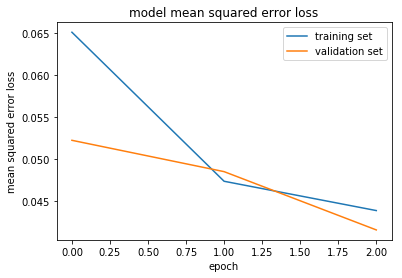

model saved!


In [12]:
model.compile(loss='mse', optimizer='adam')

# Once the model is compiled we'll train the feature and label arrays
# we just build.
# WE also shuffle the data and also split off 20% of the data to use 
# for validation set.

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples), validation_data =
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=3, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
# Now we will save the model and download it onto our local machine,
# and see if it works for driving the simulator.

model.save('model_trial10_v5_rgb_newdata_secondtrack_included.h5')
print("model saved!")
exit()

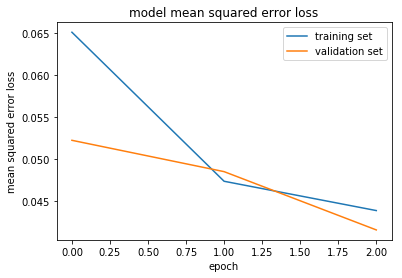

In [ ]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.savefig('loss1.png')